In [23]:
import os
import shutil
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from PIL import Image


In [12]:
data_path = r'D:\studia mgr EIM\ZZSN\thecarconnectionpicturedataset'
listOfFiles = os.listdir(data_path)

In [14]:
# opcja 1 - rozdzielenie na typy, w car_types przechowywane nazwy plikow
source= r'D:\studia mgr EIM\ZZSN\car_picture_dataset'

car_types= ['Van','Pickup','Station Wagon','4dr','3dr','2dr','SUV','Convertible']
# reszta to 'nan'
car_dictionary = dict.fromkeys(car_types)
for type_of_car in car_types:
    str_match = [s for s in listOfFiles if type_of_car in s]
    car_dictionary[type_of_car] = str_match
    # ponizej tworzenie folderow z posortwanymi juz zdjeciami typow, czyli tzw. klas, 
    # potrzebne do ImageFolder i DataLoader
    os.mkdir(os.path.join(source,type_of_car))
    target_dir = os.path.join(source,type_of_car)
    for fname in str_match:
        # copying the files to the destination directory
        shutil.copy2(os.path.join(data_path,fname), target_dir)

# ta komorka wykonuje sie ok. 5-6 min

In [19]:
# nie wiem do konca co ta komorka oznacza dla naszego kodu
# NVIDIA's CUDA Python provides a driver and runtime API
# w moim przypadku CUDA is false, czy zatem muszę jakoś specjalnie definiować obliczenia - CPU czy GPU ? mam i Intela i AMD Radeon
# TODO: ogarnac, co zrobic, pomoc 
cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [27]:
im = Image.open(r"D:\studia mgr EIM\ZZSN\car_picture_dataset\2dr\Acura_NSX_2003_89_17_250_30_6_71_46_174_17_RWD_2_2_2dr_yRp.jpg") 
im.show() 
# extract other basic metadata
info_dict = {
    "Filename": im.filename,
    "Image Size": im.size,
    "Image Height": im.height,
    "Image Width": im.width,
    "Image Format": im.format,
    "Image Mode": im.mode,
    "Image is Animated": getattr(im, "is_animated", False),
    "Frames in Image": getattr(im, "n_frames", 1)
}

for label,value in info_dict.items():
    print(f"{label:25}: {value}")

Filename                 : D:\studia mgr EIM\ZZSN\car_picture_dataset\2dr\Acura_NSX_2003_89_17_250_30_6_71_46_174_17_RWD_2_2_2dr_yRp.jpg
Image Size               : (320, 240)
Image Height             : 240
Image Width              : 320
Image Format             : JPEG
Image Mode               : RGB
Image is Animated        : False
Frames in Image          : 1


In [25]:
## inicjalizacja parametrow
number_of_classes = len(car_types)
number_of_epochs = 100

image_size_width = 320
image_size_height = 200
image_size=(image_size_width,image_size_height)
channels = 3 # bo RGB? czy to nie o to chodzi?
img_shape = (channels, image_size, image_size) # nie wiem, co to za parametr

batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# Size of z latent vector (i.e. size of generator input)
latent_size = 128  # TODO: co to za parametr tak naprawdę?

# rozmiar zdjec 320x213 pikseli, niektore na x240 lub x160 piskeli, dlatego niech bedzie 320x200 krakowskim targiem
# no chyba że musimy mieć kwadrat, jest tak podanych wiele przykladow i nie wiem, 
# czy przypadkiem wtedy nie ma siec latwiej sobie podzielic obrazu jesli oba rozmiary sa rowne

# z czego korzystam?
# 1) https://jovian.ai/tvscitechtalk/car-gan
# 2) https://github.com/ozanciga/gans-with-pytorch/blob/master/cgan/cgan.py

# ten poniżej kod bardziej do mnie przemawia jeśli chodzi o definicje dyskryminatora i generatora
# 3) https://github.com/eriklindernoren/PyTorch-GAN/blob/36d3c77e5ff20ebe0aeefd322326a134a279b93e/implementations/cgan/cgan.py#L189

train_ds = ImageFolder(source, transform=T.Compose([
    #T.Resize((image_size_width,image_size_height)),
    T.Resize((image_size_height,image_size_width)),
    T.ToTensor(),
    T.Normalize(*stats)])) # normalizacja, zeby dyskryminator mial latwiej-?

# TODO: czy wgl cos tu dodatkowo ustawiac?
train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)


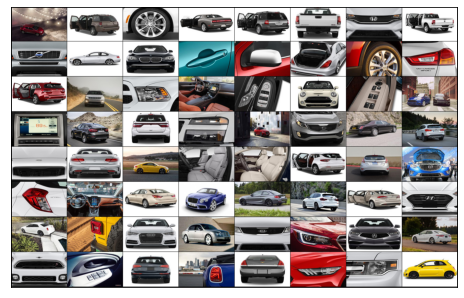

In [26]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [ ]:
## klasa generatora - póki co idea skopiowana z linku 3)
# nn.Module - base class for all neural network modules
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # TODO: okreslic wlasciwe parametry w funkcji ponizej
        self.label_emb = nn.Embedding(number_of_classes, number_of_classes)

        # TODO: wypróbować Conv2d ale i sprawdzić jak zachowuje siec sieć przy nn.Linear

        def block(in_feat, out_feat, normalize=True):
                # layers = [nn.Linear(in_feat, out_feat)]
                layers = [nn.Conv2d(in_feat, out_feat)]
                if normalize:
                    layers.append(nn.BatchNorm1d(out_feat, 0.8))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
                return layers

        self.model = nn.Sequential(
            *block(latent_size + number_of_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

In [ ]:
## klasa dyskryminatora - póki co idea skopiowana z linku 3)
class Discriminator(nn.Module):
    def __init__(self):
            super(Discriminator, self).__init__()

            self.label_emb = nn.Embedding(number_of_classes, number_of_classes)

            self.model = nn.Sequential(
            nn.Linear(number_of_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [ ]:
# entropia krzyzowa 
# TODO: ustalenie parametrow

# nn.BCELoss -> binary cross entropy
# nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=- 100, 
#     reduce=None, reduction='mean', label_smoothing=0.0) -> zwykla entropia

In [ ]:
# ----------
#  Training
# ----------

# for epoch in range(number_of_epochs):
#     for i, (imgs, labels) in enumerate(train_dl):


In [ ]:
# wyliczenia FID i IS jako ostatni etap